In [41]:
import numpy as np
import pickle
import csv
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import font_manager as fm, rcParams
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from cycler import cycler
from datetime import datetime
from tools import load, estimate_derivative
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


In [42]:
# path = r"/home/p308270/.local/share/fonts/Helvetica.ttf"  # or .otf
# path = r"/home/ton20/.local/share/fonts/Helvetica.ttf"  # or .otf

# fm.fontManager.addfont(path)
palette = ['#405cca', '#c23232', '#269f30', '#1d1d1d']
cmap = ListedColormap(palette, name='custom')
plt.rcParams.update({
    "font.size": 12,
    "font.family": "Helvetica",
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,
    "axes.prop_cycle": cycler(color=palette),

    "lines.linewidth": 1.5,     # default line width
    "axes.linewidth": 1.,      # axis spine width
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.width': 1.0,
    'ytick.minor.width': 1.0,

    "hatch.linewidth": 1.,   # make hatch strokes visible

})
rng = np.random.default_rng(42)  # for reproducibility

In [43]:
file = '1_600_20'

sensor_data = []
times = []
with open(f'data/{file}.csv', 'r') as f:
    reader = csv.reader(f)
    # times = [row[0] for row in reader]
    for row in reader:
        if row[0] =='Timestamp':
            continue
        else:
            times.append(row[0])
            values = []
            for i in range(17):
                b1 = int(row[2*i+1])
                b2 = int(row[2*i+2])
                values.append(int.from_bytes([b1, b2], byteorder="little"))
            sensor_data.append(values)
sensor_data = np.array(sensor_data)
sequence = pickle.load(open(f'data/{file}_sequence.pkl', 'rb'))

d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=sensor_data)

In [44]:
responding_sens = [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
sensor_id = ["TGS2602", "TGS2610", "SP3S-AQ2", "GSBT11-DXX",
             "TGS2600", "TGS2603", "TGS2630", "TGS2612",
             "TGS2620", "MG-812", "TGS3830", "TGS1820",
             "TGS2611", "TGS2616", "WSP2110", "TGS-3870",
             "BME680"]

/tmp/ipykernel_77866/3317206563.py:260: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


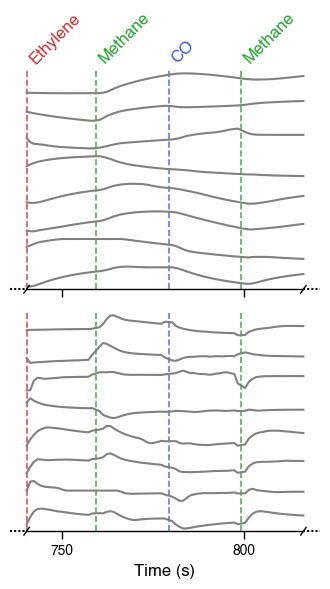

In [45]:
_, _, times_sec, sequence_sec = load(filename, reduced=True)

# Rebase to seconds since the first value in sensor_data
t0 = float(times_sec[0])
t_secs0 = times_sec - t0


# ----------------------------
# Window selection (inclusive indices)
# ----------------------------
idx_start, idx_end = 717, 790
idx_start = max(0, int(idx_start))
idx_end = min(len(times_sec) - 1, int(idx_end))
if idx_end <= idx_start:
    raise ValueError("idx_end must be greater than idx_start.")

sl = slice(idx_start, idx_end + 1)
t_sub = t_secs0[sl]   # windowed time in seconds since start

# ----------------------------
# Figure / axes (two subplots: top = sensor_data, bottom = d_sensor_data)
# ----------------------------
fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1,
    figsize=(4, 6),
    sharex=True,
    gridspec_kw={"hspace": 0.1},
)

# ----------------------------
# Trace placement constants
# ----------------------------
idxs = [i for i, v in enumerate(responding_sens) if v == 1]
names = [re.sub(r'^\s*UX\s*-\s*', '', sensor_id[i]) for i in idxs]

TARGET_HALF_HEIGHT = 0.9
TRACE_SCALE        = 0.8
AMP                = TRACE_SCALE * TARGET_HALF_HEIGHT  # ~0.72

if len(idxs) > 0:
    bottom_of_lowest = -AMP
    top_of_highest   = 2 * (len(idxs) - 1) + AMP
else:
    bottom_of_lowest = 0.0
    top_of_highest   = 1.0

LABEL_HEADROOM = -0.2
y_label_data   = top_of_highest + 0.5
ymin_fixed     = bottom_of_lowest - 0.20
ymax_fixed     = y_label_data + LABEL_HEADROOM

for ax in (ax_top, ax_bottom):
    ax.set_ylim(ymin_fixed, ymax_fixed)
    ax.set_autoscale_on(False)

# ----------------------------
# Background gas rectangles  (axvspan -> x=data, y=axes)
# ----------------------------
max_len_blocks = 20
rect_alpha     = 0.15

gas_names = {1: "CO", 2: "Ethylene", 3: "Methane"}
def _gas_label(lab: int) -> str:
    return gas_names.get(int(lab), f"Gas {int(lab)}")

# per-sample gas labels over full recording
colour_full = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end   = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour_full[mask] = int(sequence[i][1])  # adjust if your sequence structure differs

labels_local = colour_full[sl]
x_window     = t_sub

def _find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0:
        return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s,e)
                    s = e
            start, prev = i, cur
    return blocks

def _block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s - 1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e - 1] + x[e])
    return L, R

blocks = _find_blocks(labels_local, max_len=max_len_blocks, ignore=0)

def draw_gas_rectangles(ax):
    """Draw vertical gas mixture rectangles on given axes."""
    for s, e, lab in blocks:
        if lab == 0:
            continue
        L, R = _block_edges_from_indices(x_window, s, e)
        if R <= L:
            continue
        ax.axvspan(
            L, R, ymin=0.0, ymax=1.0,
            facecolor=cmap((int(lab) - 1) % cmap.N),
            alpha=rect_alpha, linewidth=0, zorder=0
        )

def draw_gas_lines(ax):
    """Draw vertical gas mixture rectangles on given axes."""
    for s, e, lab in blocks:
        if lab == 0:
            continue
        L, R = _block_edges_from_indices(x_window, s, e)
        if R <= L:
            continue
        ax.axvline(
            L, ymin=0.0, ymax=1.0,
            color=cmap((int(lab) - 1) % cmap.N),
            alpha=0.8, linewidth=1.2, linestyle='--', zorder=0
        )

def draw_gas_labels(ax):
    """Draw gas labels on given axes (data coordinates)."""
    seen_for_label = set()
    x_text_offset = -0.5
    for s, e, lab in blocks:
        if lab == 0 or lab in seen_for_label:
            continue
        L, R = _block_edges_from_indices(x_window, s, e)
        if R <= L:
            continue
        # seen_for_label.add(lab)
        x_mid = 0.5 * (L + R)
        x_lbl = x_mid + x_text_offset * (R - L)
        ax.text(
            x_lbl, y_label_data, _gas_label(lab),
            transform=ax.transData, ha='left', va='bottom',
            rotation=45,
            color=cmap((int(lab) - 1) % cmap.N),
            clip_on=False, zorder=5
        )

# Draw gas rectangles on both subplots
for ax in (ax_top, ax_bottom):
    draw_gas_lines(ax)

# Gas labels ONLY on the top subplot
draw_gas_labels(ax_top)

# ----------------------------
# Traces (helper reused for sensor_data and d_sensor_data)
# ----------------------------
EPS = 1e-12
BASELINE_LEN = 300

def plot_traces_for_matrix(ax, data_matrix):
    """Plot stacked traces for the given data matrix on the given axes."""
    for k, i in enumerate(idxs):
        row = data_matrix.T[i]
        b_len = min(BASELINE_LEN, len(row))
        baseline = float(np.mean(row[:b_len]))
        signal = (row - baseline) / 65536.0
        s_sub = np.asarray(signal)[sl]

        s_min, s_max = float(np.min(s_sub)), float(np.max(s_sub))
        s_mid = 0.5 * (s_max + s_min)
        p2p  = max(s_max - s_min, EPS)
        s_scaled = (s_sub - s_mid) * (TARGET_HALF_HEIGHT / (0.5 * p2p + EPS))

        ax.plot(
            t_sub,
            TRACE_SCALE * s_scaled + 2 * k,
            zorder=2,
            c='grey',  # uncomment if you want a fixed color
        )

# Top: original sensor_data
plot_traces_for_matrix(ax_top, sensor_data)

# Bottom: d_sensor_data
plot_traces_for_matrix(ax_bottom, d_sensor_data)

# ----------------------------
# Axis decorations helper (dashed extensions + slashes)
# ----------------------------
def decorate_x_axis_with_slashes(ax, x0, x1, ext_frac=0.06):
    """Draw dashed extensions and diagonal slashes at the x-axis window edges on a given axes."""
    Lx = x1 - x0
    ext = ext_frac * Lx

    # Extend limits
    ax.set_xlim(x0 - ext, x1 + ext)

    xmin, xmax = ax.get_xlim()
    span = xmax - xmin
    slash_w = 0.02 * span
    slash_h = 0.02

    axis_color = ax.spines["bottom"].get_edgecolor()
    xax = ax.get_xaxis_transform()

    # Dashed continuations
    for x_pair in [(x0 - ext, x0), (x1, x1 + ext)]:
        ax.add_line(Line2D(
            x_pair, [0, 0],
            transform=xax,
            linestyle=(0, (1., 1.)),
            linewidth=1.5,
            color=axis_color,
            solid_capstyle="butt",
            clip_on=False,
            zorder=3,
        ))

    # Restrict the visible bottom spine
    ax.spines["bottom"].set_bounds(x0, x1)

    # Slashes at the window boundaries
    for xc in (x0, x1):
        ax.add_line(Line2D(
            [xc - 0.5 * slash_w, xc + 0.5 * slash_w],
            [-slash_h, slash_h],
            transform=xax,
            linewidth=1.,
            color=axis_color,
            solid_capstyle="butt",
            clip_on=False,
            zorder=4,
        ))

# ----------------------------
# Stylistic tweaks (spines, ticks)
# ----------------------------
# No y-ticks (you had them removed)
for ax in (ax_top, ax_bottom):
    ax.set_yticks([])
    ax.spines[["top", "right", "left"]].set_visible(False)
    ax.tick_params(left=False, labelleft=True)

# X-ticks only on the bottom axis, with labels and xlabel
ax_top.tick_params(axis='x', labelbottom=False)
ax_bottom.set_xticks([750, 800])
ax_bottom.set_xlabel("Time (s)")

plt.tight_layout()

# ----------------------------
# Axis decorations (x-axis only) – apply to BOTH subplots
# ----------------------------
x0, x1 = t_secs0[idx_start], t_secs0[idx_end]
decorate_x_axis_with_slashes(ax_top, x0, x1)
decorate_x_axis_with_slashes(ax_bottom, x0, x1)

# ----------------------------
# Save & show
# ----------------------------
plt.savefig('figs/model_signal.png', dpi=500)
plt.savefig('figs/model_signal.pdf', dpi=500)
plt.show()


In [46]:
data, _, _, _ = load('1_600_20', reduced=True)
d_data = np.apply_along_axis(estimate_derivative, axis=0, arr=data)
signal = np.hstack((data, d_data))

In [75]:
idx = np.where(signal[:, 8]==np.max(signal[:, 8]))[0]
x_dense = signal[idx]

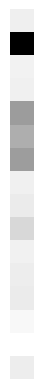

In [85]:
fig, ax = plt.subplots(1, 1)

ax.imshow(x_dense.T, cmap='binary')
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('figs/model_dense.pdf', bbox_inches='tight', dpi=500)

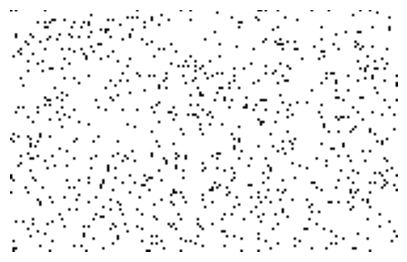

In [79]:
W_hd = np.random.binomial(n=1, p=0.05, size=(1000, 16))
img = np.resize(W_hd, (100, 160))
# img = W_hd

fig = plt.figure(figsize=(5, 10))
ax = fig.add_subplot(111)

ax.imshow(img, cmap='binary')
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])

plt.savefig('figs/model_w_hd.pdf', bbox_inches='tight', dpi=500)
plt.show()

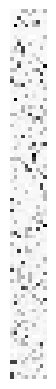

In [91]:
z_dense = x_dense @ W_hd.T

fig, ax = plt.subplots(1, 1)
img = np.resize(z_dense, (100, 10))
ax.imshow(img, cmap='binary')
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('figs/model_hd_dense.pdf', bbox_inches='tight', dpi=500)

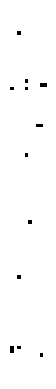

In [92]:
z_sparse = np.where(np.argsort(z_dense)<15, 1., 0)

fig, ax = plt.subplots(1, 1)
img = np.resize(z_sparse, (100, 10))
ax.imshow(img, cmap='binary')
ax.spines[['left', 'bottom']].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('figs/model_hd_sparse.pdf', bbox_inches='tight', dpi=500)